# UMAP MODEL 

In [1]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

from sklearn import metrics
import math

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
import umap


## DATA LOADING


This notebook goal is building a model based on UMAP dimensionallity reduction to predict the Remaining Useful Life of a certain instance.

On this purpose, first a UMAP projection is going to be built.

Once we have the projection, we apply it over the new point that we would like to predict. This point, in case that the projection results are good enough, will be near to other instances in a similar health situation.

The last step is selecting a number of "nearest neighbours", based on the two new axes, and predicting as the final outcome the remaining useful life of those. 

In [3]:
train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD003.txt", delimiter = ' ')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD003.txt", delimiter = ' ')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD003.txt")


In [4]:
#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)


In [5]:
###TEST DATA SET###

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)


### DATA VECTOR PREPARATION

On this stage, I am going to prepare the data vectors that we are using as input for the UMAP projection.


In [ ]:
train_df.head()

In [6]:
train_cols = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
train_vector = train_df[train_cols]

train_vector.head()

BPR      NRc      NRf       Nc       Nf  Nf_dmd     OP1     OP2    OP3  \
0  8.4246  8145.32  2388.01  9062.17  2387.96    2388 -0.0005  0.0004  100.0   
1  8.4403  8152.85  2388.03  9061.78  2388.00    2388  0.0008 -0.0003  100.0   
2  8.3901  8150.17  2388.00  9070.23  2388.03    2388 -0.0014 -0.0002  100.0   
3  8.3878  8146.56  2388.08  9064.57  2388.00    2388 -0.0020  0.0001  100.0   
4  8.3869  8147.80  2388.03  9076.14  2388.04    2388  0.0016  0.0000  100.0   

     P15  ...      T2     T24      T30      T50    W31      W32  epr  farB  \
0  21.61  ...  518.67  642.36  1583.23  1396.84  39.11  23.3537  1.3  0.03   
1  21.61  ...  518.67  642.50  1584.69  1396.89  38.99  23.4491  1.3  0.03   
2  21.61  ...  518.67  642.18  1582.35  1405.61  38.85  23.3669  1.3  0.03   
3  21.61  ...  518.67  642.92  1585.61  1392.27  38.96  23.2951  1.3  0.03   
4  21.61  ...  518.67  641.68  1588.63  1397.65  39.14  23.4583  1.3  0.03   

   htBleed     phi  
0      391  522.31  
1      392  522.42  
2      391  522.03  
3      392  522.49  
4      392  522.58  

[5 rows x 24 columns]

In [7]:
test_vector = test_df[train_cols]

test_vector.head()

BPR      NRc      NRf       Nc       Nf  Nf_dmd     OP1     OP2    OP3  \
0  8.3760  8133.48  2387.94  9048.65  2387.93    2388 -0.0017 -0.0004  100.0   
1  8.4062  8137.44  2388.01  9046.53  2387.94    2388  0.0006 -0.0002  100.0   
2  8.3553  8138.25  2387.94  9054.92  2387.97    2388  0.0014 -0.0003  100.0   
3  8.3709  8137.07  2387.96  9055.04  2387.94    2388  0.0027  0.0001  100.0   
4  8.4146  8134.20  2387.97  9048.59  2388.01    2388 -0.0001  0.0001  100.0   

     P15  ...      T2     T24      T30      T50    W31      W32  epr  farB  \
0  21.58  ...  518.67  641.94  1581.93  1396.93  39.07  23.4468  1.3  0.03   
1  21.58  ...  518.67  642.02  1584.86  1398.90  39.04  23.4807  1.3  0.03   
2  21.58  ...  518.67  641.68  1581.78  1391.92  39.10  23.4244  1.3  0.03   
3  21.59  ...  518.67  642.20  1584.53  1395.34  38.97  23.4782  1.3  0.03   
4  21.58  ...  518.67  642.46  1589.03  1395.86  39.09  23.3950  1.3  0.03   

   htBleed     phi  
0      391  521.89  
1      391  521.85  
2      391  522.10  
3      392  522.45  
4      391  521.91  

[5 rows x 24 columns]

In [8]:
test_lastcycle = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
    for id in test_df['Unit'].unique()]).reset_index(drop = True)

In [9]:
RUL_test = test_lastcycle['RUL']


In [ ]:
test_df[test_df['Unit']==1].tail()

## UMAP MODEL FITTING

In [10]:
train_v = (train_vector.to_numpy())
test_v = (test_lastcycle[train_cols].to_numpy())

In [11]:
print(train_v.shape, test_v.shape)

(24720, 24) (100, 24)


In [12]:
trans = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.25, metric='chebyshev').fit(train_v) # Projection calculation
train_emb = trans.embedding_ # Projection over the euclidean space
test_emb = trans.transform(test_v) # Projection test data set over the euclidean space

In [ ]:
train_df.head()

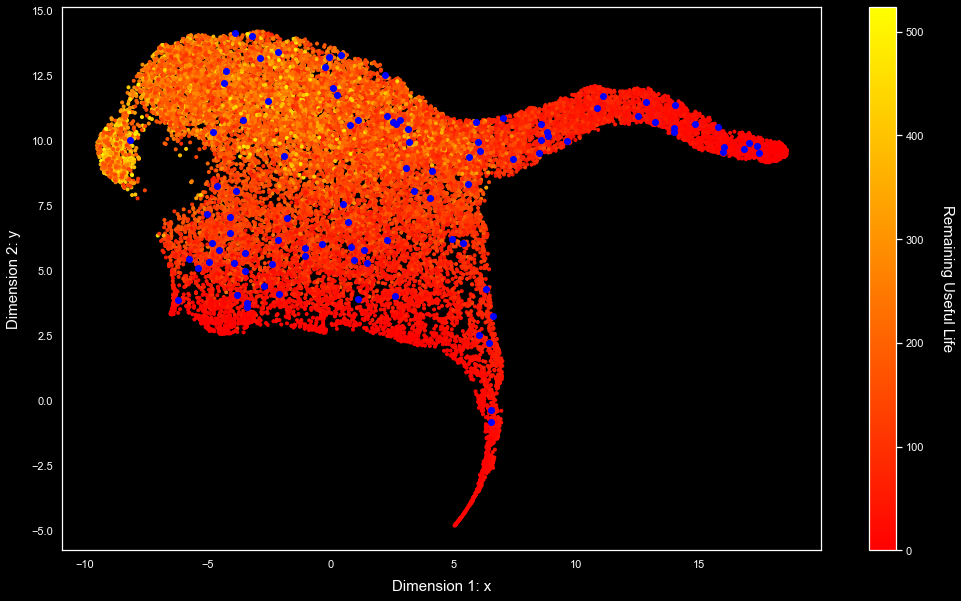

In [13]:
plt.style.use('dark_background')

fig = plt.figure(figsize = (17,10) )

ax = fig.add_subplot(111)

plot = ax.scatter(train_emb[:,0], train_emb[:,1], c = train_df['RUL'], cmap= 'autumn', marker = '.', label = 'Useful Lifetime')

cbar = plt.colorbar(plot)

cbar.ax.set_ylabel('Remaining Useful Life', rotation = 270, size = 15, labelpad = +30)

plot = ax.scatter(test_emb[:,0], test_emb[:,1],  color = 'blue', marker = 'o')

ax.set_xlabel("Dimension 1: x", size = 15, labelpad = 10)
ax.set_ylabel("Dimension 2: y", size = 15, labelpad = 10)
ax.tick_params(colors = 'white')


fig.show()

In [ ]:
plt.style.use('dark_background')

fig = plt.figure(figsize = (17,10) )

ax = fig.add_subplot(111)
plot = ax.scatter(train_emb[:,0], train_emb[:,1], c = train2['UL'], cmap= 'autumn', marker = '.', label = 'Useful Lifetime')

ax.set_xlabel("Dimension 1: x", size = 15, labelpad = 10)
ax.set_ylabel("Dimension 2: y", size = 15, labelpad = 10)
ax.tick_params(colors = 'white')


cbar = plt.colorbar(plot)

cbar.ax.set_ylabel('Remaining Useful Life', rotation = 270, size = 15, labelpad = +30)




fig.show()

In [ ]:
plt.style.use('dark_background')

plt.scatter(train_emb[:,0], train_emb[:,1], c = train2['RUL_index'], cmap= 'autumn', marker = '.', label = 'Remaining Useful Index')

plt.colorbar()
plt.xticks()
plt.yticks()
plt.legend()

In [ ]:
train_df.head()

In [30]:
RUL_train = train_df['RUL'].to_numpy()

RUL_train[RUL_train>150]=150

print(RUL_train.shape)


(24720,)


In [31]:
NN = 20

distances = metrics.pairwise_distances(test_emb,train_emb)

RUL_predict = np.zeros(len(test_emb))
RUL_index_predict = np.zeros(len(test_emb))

for i in range(len(test_emb)):

    print('Unidad:', i)

    maxs = np.zeros(NN)

    dist = np.zeros((len(train_emb),2))
    dist[:,0] = range(len(train_emb))
    dist[:,1] = distances[i,:]

    #display(dist)
    #print(dist.shape)

    #display(np.sort(dist[:,1]))

    for j in range(NN):

        #print(np.argmin(dist[:,1]))
        #print(dist[np.argmin(dist[:,1]),1])
        

        maxs[j] = dist[np.argmin(dist[:,1]),0]

        dist = np.delete(dist, obj = np.argmin(dist[:,1]), axis = 0)
    
    RUL_predict[i] = round(np.mean(RUL_train[[maxs.astype(int)]]))

    #print("Maxs: ", maxs)
    #print(RUL_train[maxs.astype(int)])

Unidad: 0
Unidad: 1
Unidad: 2
Unidad: 3
Unidad: 4
Unidad: 5
Unidad: 6
Unidad: 7
Unidad: 8
Unidad: 9
Unidad: 10
Unidad: 11
Unidad: 12
Unidad: 13
Unidad: 14
Unidad: 15
Unidad: 16
Unidad: 17
Unidad: 18
Unidad: 19
Unidad: 20
Unidad: 21
Unidad: 22
Unidad: 23
Unidad: 24
Unidad: 25
Unidad: 26
Unidad: 27
Unidad: 28
Unidad: 29
Unidad: 30
Unidad: 31
Unidad: 32
Unidad: 33
Unidad: 34
Unidad: 35
Unidad: 36
Unidad: 37
Unidad: 38
Unidad: 39
Unidad: 40
Unidad: 41
Unidad: 42
Unidad: 43
Unidad: 44
Unidad: 45
Unidad: 46
Unidad: 47
Unidad: 48
Unidad: 49
Unidad: 50
Unidad: 51
Unidad: 52
Unidad: 53
Unidad: 54
Unidad: 55
Unidad: 56
Unidad: 57
Unidad: 58
Unidad: 59
Unidad: 60
Unidad: 61
Unidad: 62
Unidad: 63
Unidad: 64
Unidad: 65
Unidad: 66
Unidad: 67
Unidad: 68
Unidad: 69
Unidad: 70
Unidad: 71
Unidad: 72
Unidad: 73
Unidad: 74
Unidad: 75
Unidad: 76
Unidad: 77
Unidad: 78
Unidad: 79
Unidad: 80
Unidad: 81
Unidad: 82
Unidad: 83
Unidad: 84
Unidad: 85
Unidad: 86
Unidad: 87
Unidad: 88
Unidad: 89
Unidad: 90
Unidad: 9

In [32]:
print(RUL_predict)

[ 49. 120.  32. 134. 147.  98.  83. 106. 100. 121. 131. 115.  91.  99.
 140. 139. 121. 142. 134.  73.  28. 139.  75.   8.  61.  33. 112. 100.
 121.  72.  68.  52.  94.  84. 124. 142. 141.  53.   7.  46. 138. 103.
 145. 101. 119.  15. 131.  84. 146.  43. 102. 132. 110. 117.  33.  89.
  94. 106.  52. 140. 143.  82. 128.  36. 144. 106. 114. 138. 126.  90.
  29.  89. 113. 143.  59.  61.  64.  24.  37. 150.  29.   9. 116. 129.
  95.  22.  78. 146.  98.  55. 125.  18. 124.   9. 136.  78. 146.  21.
  14.  35.]


In [33]:
print(RUL_predict.shape, RUL_test.to_numpy().shape)

(100,) (100,)


In [34]:
error = RUL_predict - RUL_test
abs_error = np.absolute(error)
mean_error = np.mean(abs_error)


print("Mean RUL error: " , mean_error )



Mean RUL error:  20.96


The model score is: 2059.3252360014267
The model accuracy is: 38.0
The model MAE is: 20.96
The model MSE is : 763.7
The model Mean Absolute Percentage Error (MAPE) is: 24.91483045981146
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 10.100703241420328


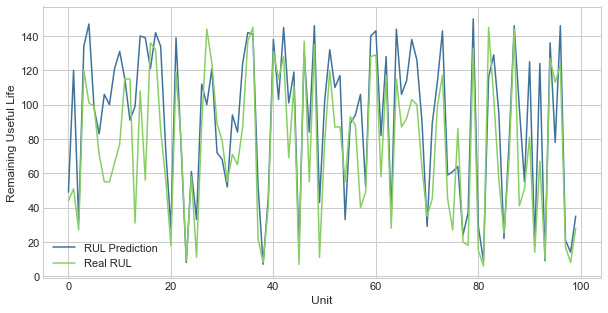

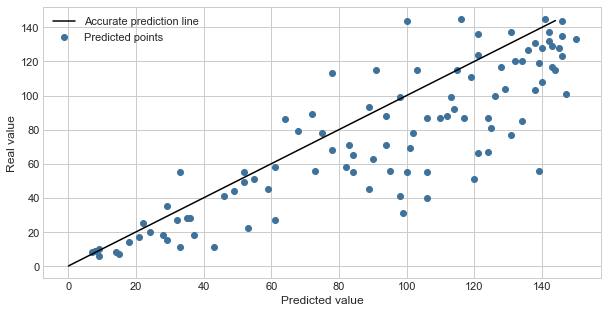

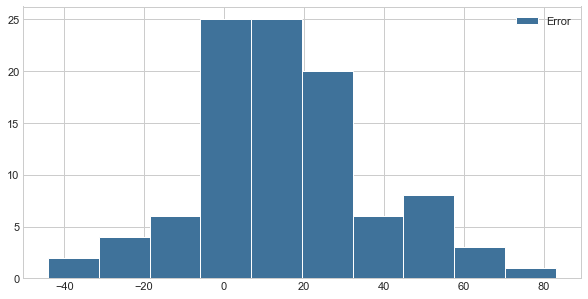

In [35]:
plt.style.use('seaborn-whitegrid')
from Perform_function import perform_func 
y_pred_test = RUL_predict
y_true_test = RUL_test

_, _, _, _, _, _ = perform_func(y_pred_test, y_true_test, test_df.groupby('Unit').max()['Cycle'].to_numpy())

In [36]:
test_lastcycle['RUL_predict'] = RUL_predict
test_lastcycle['RUL_test'] = RUL_test.to_numpy()[:,0]
test_lastcycle['error'] = error
test_lastcycle['Absolute_error'] = abs_error
test_lastcycle['Embedding_x'] = test_emb[:,0]
test_lastcycle['Embedding_y'] = test_emb[:,1]



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(test_lastcycle[test_lastcycle['Absolute_error'] > 30])
print(len(test_lastcycle[test_lastcycle['Absolute_error'] > 30]))


In [ ]:
print(error)

error.shape

In [ ]:
RUL_test

In [ ]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,5))
plt.plot(range(len(test_emb)), RUL_predict, color = "#3f729a", label = 'Prediction')
plt.plot(range(len(test_emb)), RUL_test, color = "#89ce65", label = 'Real')
#plt.plot(range(len(test_emb[:130])), abs_error[:130], color = 'red', label = 'Error')

plt.ylabel('Remaining Useful Life')
plt.xlabel('Unit')

plt.xticks(range(0,100,10))

plt.legend()

In [ ]:
plt.figure(figsize = (30,5))
plt.plot(range(130, len(test_emb)), RUL_predict[130:], color = 'white', label = 'Prediction')
plt.plot(range(130, len(test_emb)), RUL_test[130:], color = 'green', label = 'Real')
plt.plot(range(130, len(test_emb)), abs_error[130:], color = 'red', label = 'Error')

plt.ylabel('Remaining Useful Life', size = 15)
plt.xlabel('Unit', size = 15)

plt.xticks(range(130,260,10))

plt.legend(fontsize = 'large')


In [ ]:
distances = metrics.pairwise_distances(test_emb,train_emb)

display(distances)

print(distances.shape)

In [ ]:
print(math.sqrt((test_emb[0,0]-train_emb[1,0])**2 + (test_emb[0,1]-train_emb[1,1])**2 ))

In [ ]:
plt.style.use('dark_background')

plt.scatter(train_emb[:,0], train_emb[:,1], c = train2['RUL_index'], cmap= 'autumn', marker = '.', label = 'Train')

plt.colorbar()
plt.scatter(test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Embedding_x'], test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Embedding_y'], c = test_lastcycle[test_lastcycle['Absolute_error'] > 10]['Absolute_error'] , cmap = 'cool', marker= 'o')
plt.colorbar()

In [ ]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.scatter(RUL_predict, RUL_test, c = "#3f729a", marker = 'o')
ax.plot(range(200), range(200), c = 'black')

ax.set_ylabel('Real value')
ax.set_xlabel('Predicted value')

In [ ]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(RUL_predict, RUL_test[:,0], test2.groupby('Unit').max()['Cycle'].to_numpy())

In [ ]:
test2.head()

In [ ]:
print(RUL_predict.shape, RUL_test.shape)

#### SCORE METRIC

In [ ]:
s = np.zeros(len(RUL_predict))

a_1 = 10
a_2 = 13

for i in range(len(error)):

    if error[i] < 0 : 

        s[i] = math.exp(-error[i]/a_1) - 1 
    else : 
        s[i] = math.exp(error[i]/a_2) - 1

performance_evaluation = np.sum(s)

print('The model performance evaluation is:', performance_evaluation)



In [20]:
NN = 20

distances = metrics.pairwise_distances(train_emb,train_emb)

RUL_train_predict = np.zeros(len(train_emb))
RUL_index_train_predict = np.zeros(len(train_emb))

for i in range(len(train_emb)):

    print('Unidad:', i)

    maxs = np.zeros(NN)

    dist = np.zeros((len(train_emb),2))
    dist[:,0] = range(len(train_emb))
    dist[:,1] = distances[i,:]

    #display(dist)
    #print(dist.shape)

    #display(np.sort(dist[:,1]))

    for j in range(NN):

        #print(np.argmin(dist[:,1]))
        #print(dist[np.argmin(dist[:,1]),1])
        

        maxs[j] = dist[np.argmin(dist[:,1]),0]

        dist = np.delete(dist, obj = np.argmin(dist[:,1]), axis = 0)
    
    RUL_train_predict[i] = round(np.mean(RUL_train[[maxs.astype(int)]]))

    #print("Maxs: ", maxs)
    #print(RUL_train[maxs.astype(int)])


Unidad: 23291
Unidad: 23292
Unidad: 23293
Unidad: 23294
Unidad: 23295
Unidad: 23296
Unidad: 23297
Unidad: 23298
Unidad: 23299
Unidad: 23300
Unidad: 23301
Unidad: 23302
Unidad: 23303
Unidad: 23304
Unidad: 23305
Unidad: 23306
Unidad: 23307
Unidad: 23308
Unidad: 23309
Unidad: 23310
Unidad: 23311
Unidad: 23312
Unidad: 23313
Unidad: 23314
Unidad: 23315
Unidad: 23316
Unidad: 23317
Unidad: 23318
Unidad: 23319
Unidad: 23320
Unidad: 23321
Unidad: 23322
Unidad:23323
Unidad: 23324
Unidad: 23325
Unidad: 23326
Unidad: 23327
Unidad: 23328
Unidad: 23329
Unidad: 23330
Unidad: 23331
Unidad: 23332
Unidad: 23333
Unidad: 23334
Unidad: 23335
Unidad: 23336
Unidad: 23337
Unidad: 23338
Unidad: 23339
Unidad: 23340
Unidad: 23341
Unidad: 23342
Unidad: 23343
Unidad: 23344
Unidad: 23345
Unidad: 23346
Unidad: 23347
Unidad: 23348
Unidad: 23349
Unidad: 23350
Unidad: 23351
Unidad: 23352
Unidad: 23353
Unidad: 23354
Unidad: 23355
Unidad: 23356
Unidad: 23357
Unidad: 23358
Unidad: 23359
Unidad: 23360
Unidad: 23361
Unidad

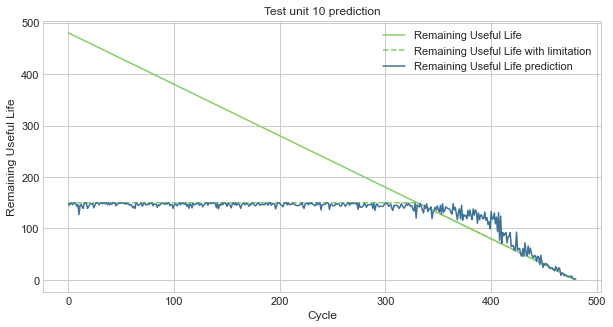

In [23]:
train_df['RUL_predict'] = RUL_train_predict

train_df['RUL_tuned'] = RUL_train

unit = 10

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)


ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_tuned'], color = "#89ce65", linestyle = '--',label = "Remaining Useful Life with limitation")
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()


In [ ]:
train_df['RUL'] = 

In [ ]:
test_lastcycle[test_lastcycle['Absolute_error'] < 10 ]['RUL_test'].mean()

In [ ]:
def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    for i in d: 
        if i<0:
            score += (e**(-i/a1) - 1)
        else : 
            score += (e**(i/a2) - 1)
    
    return score


In [ ]:
from math import e
Computed_Score(RUL_test.to_numpy()[:,0],RUL_predict)

In [ ]:
print(RUL_test.shape,RUL_predict.shape)

In [ ]:
RUL_test.to_numpy()[:,0]

In [37]:
error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_lastcycle[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] <= 160) & (error_df['RUL'] > 140) , 'Group_RUL'] = 8
error_df.loc[(error_df['RUL'] <= 180) & (error_df['RUL'] > 160) , 'Group_RUL'] = 9
error_df.loc[(error_df['RUL'] > 180) , 'Group_RUL'] = 10

In [38]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

Unit       Cycle         RUL      error  Group_RUL
Group                                                         
2      52.000000   38.000000  120.000000  12.000000   6.000000
3      63.400000   50.000000  118.800000  17.200000   6.600000
4      41.875000   71.000000  117.875000  22.125000   6.250000
5      57.000000   88.285714  115.142857  13.571429   6.285714
6      46.187500  111.750000   84.812500  29.312500   4.625000
7      29.888889  130.444444   71.000000  39.222222   4.111111
8      54.425926  225.185185   56.907407  16.740741   3.296296

In [39]:
error_grouped_RUL

error_df[error_df['Group_RUL']==0]

Empty DataFrame
Columns: [Unit, Cycle, RUL, error, Group, Group_RUL]
Index: []

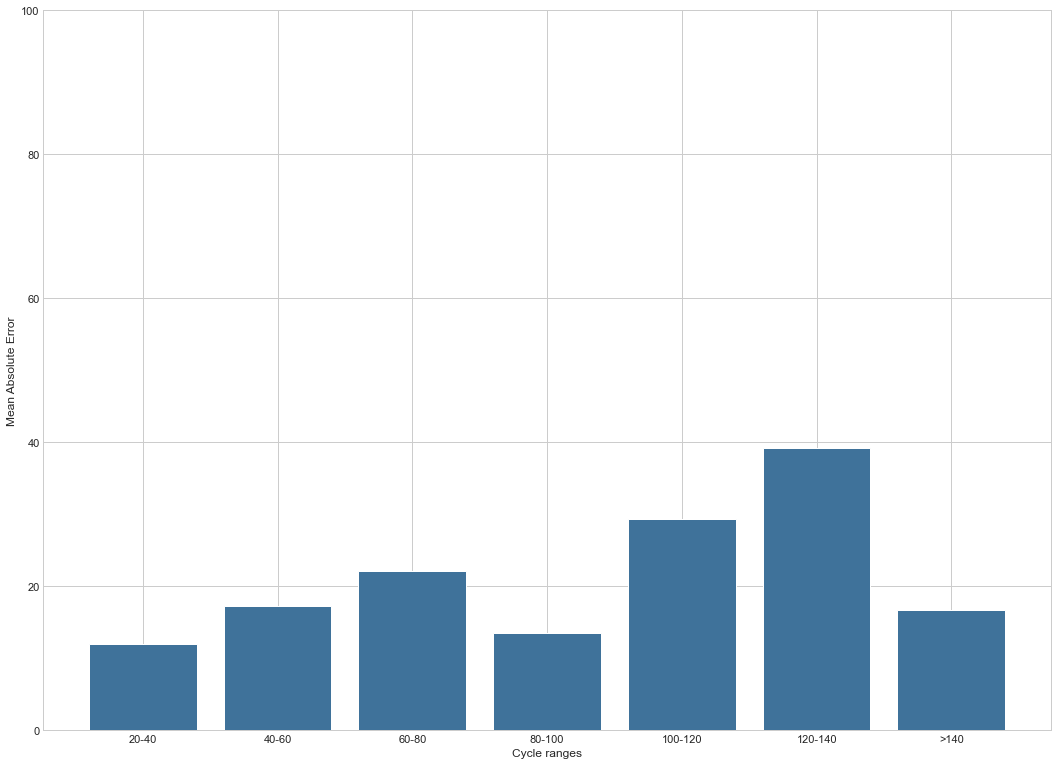

In [40]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()


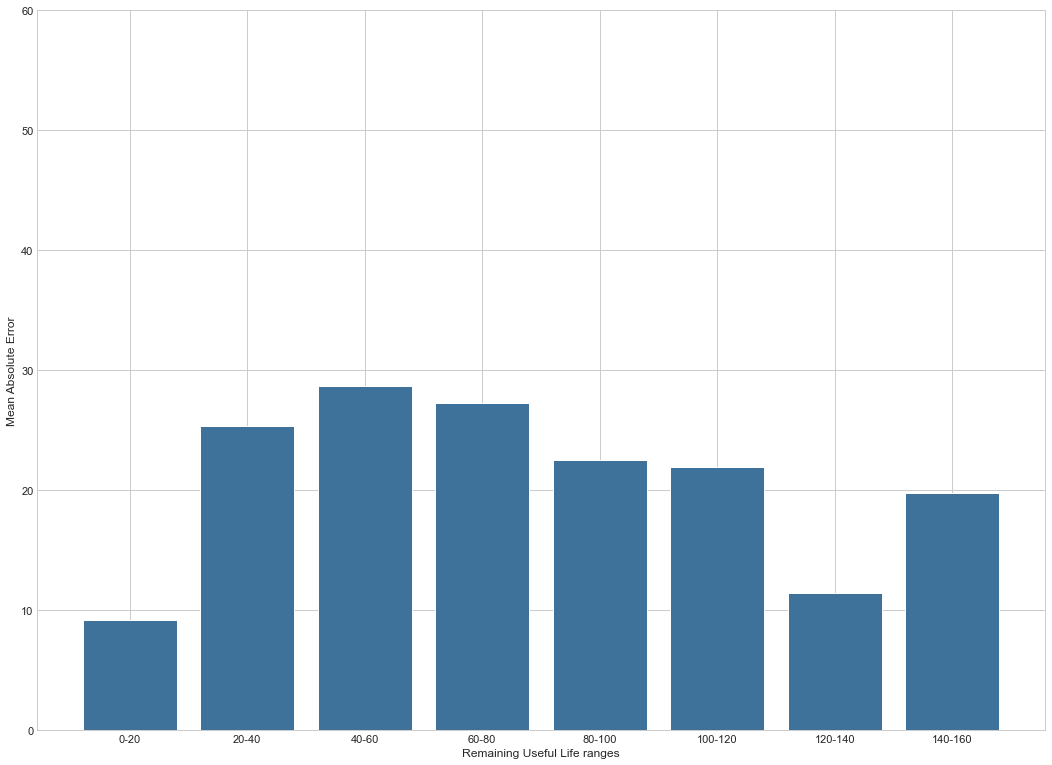

In [42]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '140-160']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,60)
plt.show()

In [ ]:
y_pred_test

In [ ]:
pd.DataFrame(y_pred_test, columns = ['RUL']).to_csv('UMAP_FD3_prediction.csv')